# Exploring a DC2 Data Repository

<br>Owner: **Rob Morgan** ([@rmorgan10](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@rmorgan10)), **Phil Marshall** ([@drphilmarshall](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@drphilmarshall)), **Alex Drlica-Wagner** ([@kadrlica](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@kadrlica))
<br>Updated for DC2 by:   Douglas Tucker ([@douglasleetucker](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@douglasleetucker)), basically copying the DC2-updated notebook created by **Johann Cohen-Tanugi** ([@johannct](https://github.com/johannct)) in the DESC fork of the Stack Club GitHub repo (https://github.com/LSSTDESC/StackClub).
<br>Last Verified to Run: **2021-03-11**
<br>Verified Stack Release: **v21.0.0**

This notebook examines the content of a data repository -- in this particular case, a DC2 data repository -- and shows how to determine the inputs for each component.  A related notebook is "Exploring an HSC Data Repository," which explores the same basic concepts, but using an HSC data repository; this other notebook covers matters in a slightly differ manner, though, and it is useful to explore both notebooks for a fuller understanding of data repositories.

### Learning Objectives:
After working through and studying this notebook you should be able to understand how to use the Butler to figure out: 
   1. What a data repo is;
   2. Which data types are present in a data repository;
   3. If coadds have been made, what the available tracts are;
   4. Which parts of the sky those tracts cover.
   
### Logistics
This notebook is intended to be runnable on `lsst-lsp-stable.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.


## Set Up

In [1]:
import os
import sys
import subprocess as sub
import warnings
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import numpy as np
import os, glob
%matplotlib inline

In [2]:
# Access DC2 calexp gen2 repository
from lsst.daf.persistence import Butler
repo = '/datasets/DC2/DR6/Run2.2i/patched/2021-02-10/rerun/run2.2i-coadd-wfd-dr6-v1'
butler = Butler(repo)

## What is a Data Repo?

A data repo is a directory containing raw images, calibration files, metadata and configuration information, defining an LSST-format dataset. Data repositories contain either a `_mapper` file or a `repositoryCfg.yaml` file, which record the "obs package" that was used to organize the data. The obs package gives the repository more structure and organization than an ordinary data directory. Let's take a look at this file structure in the DC2 data repo.

### The DC2 Data Repo: What's in there?

We'll use the dc2 data repository as our testing ground. As a production directory, it contains a lot of files presiding to the actual production pipelines, and not of interest here. 

In [3]:
# Define the top-level dir of the DC2 repo
topdir = os.path.join(repo,'../..')

In [4]:
# List the contents of `topdir`
out=sub.check_output (['ls', topdir])
print(out.decode())

CALIB
_mapper
patch_dc2_2021-02-10T162710.log
patch_dc2.screenrc
patch_dc2.yaml
raw
_raw
README.txt
ref_cats
registry.sqlite3
rerun



The important files and directories are the following :

 - **raw** directory : it contains all the raw files ingested by the butler and registered into the registry.sqlite3 database.
 - **CALIB** and **calibrations** : these hold calibration products that the Rubin science pipelines use to process the raw images.
 - **ref_cats** : a directory containing the reference catalogue(s) for astrometry and photometry calibrations.
 - **rerun** : the directory, built by the butler, that will contain all the processing outputs of the science pipelines : calibrated exposures, coadded images and catalogues, etc...
 - **_mapper** : a file that indicates to the butler what instrument is supposed to be considered for the processing task 
 
Let's have a further look at the latter.

In [5]:
out=sub.check_output (['cat', os.path.join(topdir,'_mapper')])
print(out.decode())

lsst.obs.lsst.imsim.ImsimMapper



We can see the `_mapper` file here, and it contains one line giving the name of the Mapper object for the DC2 repo:

In [6]:
# Import the Mapper object once you know its name
from lsst.obs.lsst.imsim import ImsimMapper

You can get some more information on this object like this:

In [7]:
#help(ImsimMapper)

The mapper defines a (large) number of different "dataset types". Some of these are specific to this particular data repo, others are more general. Even filtering out some intermediate dataset types, we are still left with a long list. But, once we figure out which dataset types we are interested in, we can start querying for information about those datasets.

In [8]:
mapper = ImsimMapper(root=repo)
all_dataset_types = mapper.getDatasetTypes()

remove = ['_config', '_filename', '_md', '_sub', '_len', '_schema', '_metadata']

shortlist = []
for dataset_type in all_dataset_types:
    keep = True
    for word in remove:
        if word in dataset_type:
            keep = False
    if keep:
        shortlist.append(dataset_type)

print(shortlist)

['_raw', '_raw_bbox', '_raw_detector', '_raw_filter', '_raw_header_wcs', '_raw_photoCalib', '_raw_visitInfo', '_raw_wcs', 'ampExposureId', 'ampExposureId_bits', 'analysisCoaddTable_forced', 'analysisCoaddTable_unforced', 'analysisColorTable', 'analysisMatchFullRefCoaddTable_forced', 'analysisMatchFullRefCoaddTable_unforced', 'analysisMatchFullRefVisitTable', 'analysisVisitTable', 'analysisVisitTable_commonZp', 'apCorr', 'apdb_marker', 'bias', 'bias_camera', 'binned_sensor_fits', 'binned_sensor_fits_halves', 'brightObjectMask', 'brightStarStamps', 'brighterFatterGain', 'brighterFatterKernel', 'cal_ref_cat', 'calexp', 'calexpBackground', 'calexp_bbox', 'calexp_camera', 'calexp_detector', 'calexp_filter', 'calexp_header_wcs', 'calexp_photoCalib', 'calexp_visitInfo', 'calexp_wcs', 'camera', 'ccdExposureId', 'ccdExposureId_bits', 'chiSquaredCoaddId', 'chiSquaredCoaddId_bits', 'cpPipePlotRoot', 'crosstalk', 'crosstalkCalib', 'dark', 'dark_camera', 'dcrCoadd', 'dcrCoaddId', 'dcrCoaddId_bits',

The `Butler`, directed by the `Mapper`, will have access to all the above dataset types. 

Another important file in the repo parent folder is `registry.sqlite3`. This database contains metadata for the **raw** images.

### Great, but where is the actual data?

We found where the raw images are, in the topdir, but the actual processing outputs are actually two level down, inside the **rerun** directory. Under **rerun** several directories correspond to dedicated parts of latest versions of the processing of the 2.2i simulations. The one we will focus on here is provided by the varaible repo defined above.

In [9]:
out=sub.check_output (['ls', repo])
print(out.decode())

config
deepCoadd
deepCoadd-results
repositoryCfg.yaml
schema
tracts_mapping.sqlite3



The **repositoryCfg.yaml** file allows the mapper to recognize that this is a data repository, and its content points the butler to additional data repositories, joined to this one.

In [10]:
out=sub.check_output(['cat', os.path.join(repo,'repositoryCfg.yaml')])
print(out.decode())

!RepositoryCfg_v1
_mapper: &id001 !!python/name:lsst.obs.lsst.imsim.ImsimMapper ''
_mapperArgs: {}
_parents:
- ../run2.2i-calexp-v1
- ../run2.2i-coadd-wfd-dr6-v1-u
- ../run2.2i-coadd-wfd-dr6-v1-grizy
- !RepositoryCfg_v1
  _mapper: *id001
  _mapperArgs: {}
  _parents: []
  _policy: null
  _root: ../..
  dirty: true
_policy: null
_root: null
dirty: true



One can recognize a relative path to the top directory (_root), the mapper content, and three parent data repositories that were chained to the one we are looking at: run2.2i-calexp-v1 contains the outputs of the exposure calibrations (single visit processing), run2.2i-coadd-wfd-dr6-v1-* which contain the outputs of the coaddition processing, while the current repository contains the final outputs, measurements and forced photometry on the coadds, and metacalibration of the shear, under the deepCoadd and deepCoadd-results directory.

## Obtaining Basic Dataset Properties Using the Butler

The butler has been instantiated above, and knows about the data repository structure and chaining, as described previously.

Now we can start using Butler methods to query metadata for the repo. For this dataset, we can look at the filters used, number of visits, number of pointings, etc. by examining the Butler's keys and metadata. For these basic properties, we will look at the calexp and src tables. The contents of these tables are derived from the processing of individual sensors, and exist in the parent folder. 

Note that the metadata is created from the raw exposures loaded into the sqlite registry. The fact that we can get metadata for a specific datasetType and dataId **does not** imply that the data exist on disk (we will check this in a subsequent step).

In [11]:
# This would be faster if only one query were issued...
visits = butler.queryMetadata('calexp', ['visit'])
ccds = butler.queryMetadata('calexp', ['detector'])
filters = butler.queryMetadata('calexp', ['filter'])
sources = butler.queryMetadata('src', ['id'])

# It is possible to specify multiple formats -- i.e., butler.queryMetadata('calexp', ['visit','ccd'])
metadata = butler.queryMetadata('calexp', ['visit','detector','filter'])

In [12]:
num_visits = len(visits)
num_ccds = len(ccds)
num_filters = len(filters)
num_sources = len(sources)
num_metadata = len(metadata)

In [13]:
print("This DC2 repo contains {} visits.".format(num_visits))
print("This DC2 repo contains {} ccds.".format(num_ccds))
print("This DC2 repo contains {} filters.".format(num_filters))
print("This DC2 repo contains {} sources.".format(num_sources))

This DC2 repo contains 31488 visits.
This DC2 repo contains 189 ccds.
This DC2 repo contains 6 filters.
This DC2 repo contains 3652662 sources.


Of course we find out that the butler sees 189 ccd possible entries (there are 189 science detectors in the camera) and 6 filters.... But here are also the grand total of visits and sources (detected on calibrated exposures, not coadded images).

### So where are the Calexps and Source Catalogs?

Notice that while we were able to get metadata for the `processCcd` outputs (the `calexp` and `src`), that **does not** guarantee that these products are on disk. The metadata is created from the raw inputs stored in the registry and a template for the derived data products. 

To check the existence of the data requires the use of the `datasetExists` method of the `butler`. Let's give this a try.

First we select the metadata for a specific calexp

In [14]:
dataId={'filter':'i','visit':665637,'detector':10}
butler.queryMetadata('calexp', ['visit','detector','filter'], dataId=dataId)

[(665637, 10, 'i')]

Ok, so we have the metadata, let's try to get the calexp...

In [15]:
try: 
    calexp = butler.get('calexp',dataId=dataId)
except Exception as e:
    print(str(e))
    print("\nWhat? Does the data exist?")

# Explicitly check for existence
exists = butler.datasetExists('calexp',dataId=dataId)
print("\nbutler.datasetExists: " + str(exists))


butler.datasetExists: True


The dataset exists, and we can decide to inspect the image, or the source catalogue associated with this visit. All this is for another tutorial!

## More on the calexps : visualizing and getting visit information 

First let's have a look at the calexp methods.

In [16]:
calexp_methods = [m for m in dir(calexp) if not m.startswith('_')]
calexp_methods

['Factory',
 'clone',
 'convertD',
 'convertF',
 'dtype',
 'getBBox',
 'getCutout',
 'getDetector',
 'getDimensions',
 'getFilter',
 'getHeight',
 'getImage',
 'getInfo',
 'getMask',
 'getMaskedImage',
 'getMetadata',
 'getPhotoCalib',
 'getPsf',
 'getVariance',
 'getWcs',
 'getWidth',
 'getX0',
 'getXY0',
 'getY0',
 'hasPsf',
 'hasWcs',
 'image',
 'mask',
 'maskedImage',
 'readFits',
 'readFitsWithOptions',
 'setDetector',
 'setFilter',
 'setImage',
 'setInfo',
 'setMask',
 'setMaskedImage',
 'setMetadata',
 'setPhotoCalib',
 'setPsf',
 'setVariance',
 'setWcs',
 'setXY0',
 'subset',
 'variance',
 'writeFits',
 'writeFitsWithOptions']

The core of a calibration exposure is a set of three images : the exposure itself, the mask flagging problematic pixels, and the variance plane. We can visualize these using the Rubin science pipeline's display module.

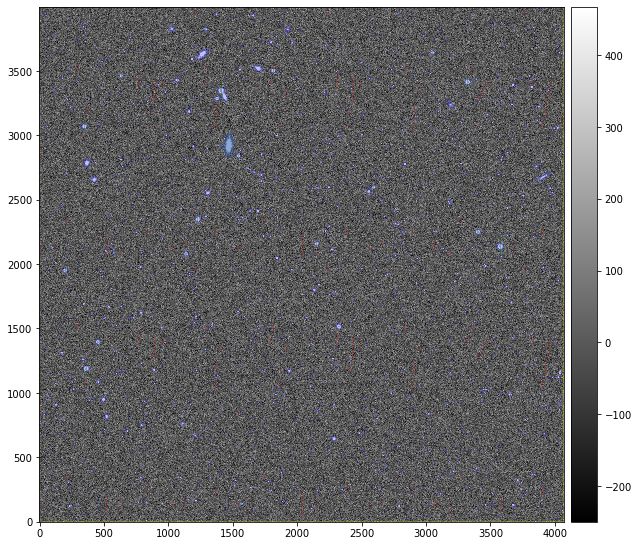

In [17]:
import lsst.afw.display as afw_display
fig = plt.figure(figsize=(10,10))
display1 = afw_display.Display(frame=1, backend='matplotlib')
display1.scale("linear", "zscale")
display1.mtv(calexp.maskedImage)

`maskedImage` shows the same exposure as calexp.image, but with the mask plane superposed. You can visualize `calexp.mask` to see the mask plane, and `calexp.variance` to visualize the noise of the ccd (you may need to comment out the scale command).

### WCS and Metadata

These are very useful information available once a calexp is retrieved:

In [18]:
wcs = calexp.getWcs()
wcs.pixelToSky(100.0, 100.0)

SpherePoint(72.27202559033022*geom.degrees, -41.216511988144894*geom.degrees)

In [19]:
metadata = calexp.getMetadata()
print(metadata.toDict())

{'CHIPID': 'R02_S01', 'OBSGEO-Y': -5208471.267364, 'OBSGEO-Z': -3195171.50942422, 'OBSGEO-X': 1818939.05374054, 'CR_SEED': '1517307449', 'AIRMASS': 1.25256587247118, 'SIMULATE': True, 'INSTRUME': 'CAMERA', 'TELESCOP': 'LSST', 'ORIGIN': 'IMSIM', 'TESTTYPE': 'IMSIM', 'OBSTYPE': 'SKYEXP', 'MONOWL': -1, 'HASTART': -44.9211477939337, 'HAEND': -44.7958055523479, 'AMSTART': 1.25256587247118, 'AMEND': 1.25014277236577, 'GAUSFWHM': 0.4, 'RN_SEED': 2759778370, 'IMSIMVER': 'v0.6.1', 'PKG00000': 'lsst_sims', 'TAG00000': 'sims_w_2019_42', 'PKG00001': 'throughputs', 'VER00001': '1.4', 'PKG00002': 'sims_skybrightness_data', 'VER00002': '2017.05.05', 'ISR_OSCAN_LEVELC10': 999.550814149354, 'ISR_OSCAN_SIGMAC10': 0.0, 'OVERSCAN': 'Overscan corrected', 'ISR_OSCAN_LEVELC11': 999.554284926977, 'ISR_OSCAN_SIGMAC11': 0.0, 'ISR_OSCAN_LEVELC12': 999.603485544447, 'ISR_OSCAN_SIGMAC12': 0.0, 'ISR_OSCAN_LEVELC13': 999.517047016772, 'ISR_OSCAN_SIGMAC13': 0.0, 'ISR_OSCAN_LEVELC14': 999.52224030377, 'ISR_OSCAN_SIGMA

### Better metadata: ExposureInfo, VisitInfo, PSF, and photometric calibration

In [20]:
calexp_info = calexp.getInfo()
visit_info = calexp_info.getVisitInfo()
visit_info.getWeather()

Weather(nan, nan, 40)

In the case of the DC2 simulation the weather is not interesting.....

In [21]:
calexp.hasPsf()

True

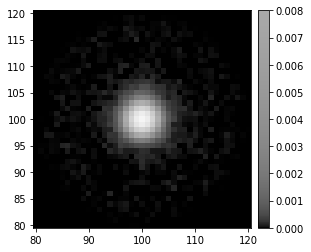

In [22]:
psf = calexp.getPsf()
from lsst.geom import PointD
psfimage = psf.computeImage(PointD(100.,100.))
display1 = afw_display.Display(frame=1, backend='matplotlib')
display1.scale('asinh', min=0.0, max=1.e-3, unit='absolute')
display1.mtv(psfimage)

In [23]:
calib = calexp.getPhotoCalib()
print(calib)
calib.getInstFluxAtZeroMagnitude() #the zero point

spatially constant with mean: 0.658715 error: 0.000237743


5511913406568.42

## Coadd Sky Area

One may also be interested in the total sky area imaged in a given processing (and thus a given repository). First let's remind ourselves that for the purpose of processing, the sky is tiled by overlapping tracts. Each tract is also divided into overlapping patches. Coaddition occurs at the patch level, while the WCS solution is constructed over the tract. The geometrical sizes of tracts and patches are configurables when defining how the processing of data from a given instrument should proceed. For DC2, there are for instance 49 patches per tract.

Let's use the repository's structure to list the available tracts :

In [24]:
# Collect tract indices from file names
tracts = sorted([int(os.path.basename(x)) for x in
                 glob.glob(os.path.join(repo, 'deepCoadd-results', 'merged', '*'))])
num_tracts = len(tracts)

print("Found {} merged tracts in repo {}".format(num_tracts, repo))

Found 166 merged tracts in repo /datasets/DC2/DR6/Run2.2i/patched/2021-02-10/rerun/run2.2i-coadd-wfd-dr6-v1


A quick way of extimating the sky area covered is to sum the areas of the inner boxes of all the tracts. For more information on the properties of tracts, you can look at the [Documentation](http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/classlsst_1_1skymap_1_1tract_info_1_1_tract_info.html).

As a quick note, the file structure only tells us the names of the tracts in the particular rerun to look at. The actual `TractInfo` objects are obtained by selecting the tracts we want from the `deepCoadd_skyMap` dataset in our particular rerun repo. Therefore, we will have to ask the `butler` to serve this dataset for the particular rerun.

In [25]:
# Calculate area from all tracts
skyMap = butler.get('deepCoadd_skyMap')
total_area = 0.0  #deg^2
plotting_vertices = []
for test_tract in tracts:
    # Get inner vertices for tract
    tractInfo = skyMap[test_tract]
    vertices = tractInfo._vertexCoordList
    plotting_vertices.append(vertices)
    
    #calculate area of box
    av_dec = 0.5 * (vertices[2][1] + vertices[0][1])
    av_dec = av_dec.asRadians()
    delta_ra_raw = vertices[0][0] - vertices[1][0] 
    delta_ra = delta_ra_raw.asDegrees() * np.cos(av_dec)
    delta_dec= vertices[2][1] - vertices[0][1]
    area = delta_ra * delta_dec.asDegrees()
    
    #combine areas
    total_area += area
    

# Round off the total area for presentation purposes
rounded_total_area = round(total_area, 2)

print("Total area imaged (sq deg): ",rounded_total_area)

Total area imaged (sq deg):  405.74


The result differs from the expected 300 sq deg for several reasons : the computation here is a flat approximation, the tracts are actually overlapping, and the DC2 processing extends beyond the strict 300 sq deg region to avoid edge effects within the fiducial region.

## Displaying Dataset Characteristics

Now let's print out a report of all the characteristics we have found above. 

In [26]:
display(Markdown('### %s' % repo))

# Make a table of the collected metadata
collected_data = [num_visits, num_ccds, num_filters, num_sources, 
                  num_tracts, rounded_total_area]
data_names = ("Number of Visits", "Number of CCDs", 
              "Number of Filters", "Number of Sources", "Number of Tracts", "Total Sky Area (deg$^2$)")
# TODO: include coadd sources and forced sources

output_table = "|   Metadata Characteristic  | Value | \n  | ---: | ---: | \n "
counter = 0
while counter < len(collected_data):
    output_table += "| %s |  %s | \n" %(data_names[counter], collected_data[counter])
    counter += 1
display(Markdown(output_table))

# Show which filters we're talking about:
display(Markdown('Filters: (%i total)' %num_filters))
print(filters)

### /datasets/DC2/DR6/Run2.2i/patched/2021-02-10/rerun/run2.2i-coadd-wfd-dr6-v1

|   Metadata Characteristic  | Value | 
  | ---: | ---: | 
 | Number of Visits |  31488 | 
| Number of CCDs |  189 | 
| Number of Filters |  6 | 
| Number of Sources |  3652662 | 
| Number of Tracts |  166 | 
| Total Sky Area (deg$^2$) |  405.74 | 


Filters: (6 total)

['i', 'y', 'g', 'r', 'u', 'z']


## Plotting the sky coverage

For this we will need our list of merged `tracts` from above, and also the `skyMap` object. We can then extract the sky coordinates of the corners of each tract, and use them to draw a set of rectangles to illustrate the sky coverage, following Jim Chiang's LSST DESC tutorial [dm_butler_skymap.ipynb](https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/dm_butler_skymap.ipynb).

In the future, we could imagine overlaying the focal plane and color the individual visits, using more of the code from Jim's notebook. Let's wait to see what functionality the Gen3 Butler provides first, and maybe return to visualization later.

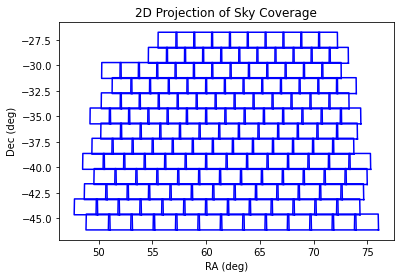

In [27]:
plt.figure()

for tract in tracts:
    tractInfo = skyMap[tract]
        
    corners = [(x[0].asDegrees(), x[1].asDegrees()) for x in tractInfo.getVertexList()]
    x = [k[0] for k in corners] + [corners[0][0]]
    y = [k[1] for k in corners] + [corners[0][1]]
    
       
    plt.plot(x,y, color='b')
    
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('2D Projection of Sky Coverage')

plt.show()

We could imagine plotting the patches as well, to show which tracts were incomplete - but this gives us a rough idea of where our data is on the sky.  More in-depth usage of the skymap can be found in other tutorials.

## Finding a Coadd Object Catalog

Since we know we have `deepCoadd` images, we might want to find the sources detected in those images. These are the precursors of `Objects`. If forced photometry has been run on these sources, there should be `deepCoadd_forced_src` catalogs present. The `config` tells us which tasks have been run in the rerun, but metadata describing the results of the run is not propagated back into the registry database in the parent folder. So, we need to get data from a separate butler which we will call in the following steps the `under_butler` (this is equivalent to the `under_butler` in the "Exploring An HSC Data Repository").

Since the registry only knows about the raw exposures (and products that can be directly derived from templates using the raws), we can't get valid metadata from `queryMetadata` directly. Instead, we query the directory structure for a valid filter, tract, patch combination.

In [28]:
dirname=os.path.join(repo,'deepCoadd-results')
print('filters: '+dirname)
!ls $dirname
filter='i'

dirname = os.path.join(dirname, filter)
print('\ntracts: '+dirname)
!ls $dirname
tract=3828

dirname = os.path.join(dirname,str(tract))
print('\npatches: '+dirname)
!ls $dirname
patch='1,3'

dirname = os.path.join(dirname,patch)
print('\ndata products: '+dirname)
!ls $dirname

filters: /datasets/DC2/DR6/Run2.2i/patched/2021-02-10/rerun/run2.2i-coadd-wfd-dr6-v1/deepCoadd-results
g  i  merged  r  u  y  z

tracts: /datasets/DC2/DR6/Run2.2i/patched/2021-02-10/rerun/run2.2i-coadd-wfd-dr6-v1/deepCoadd-results/i
2723  2896  3074  3256	3441  3454  3643  3837	4034  4235  4440  4647	5065
2724  2897  3075  3257	3442  3631  3825  4022	4035  4236  4441  4648	5066
2725  2898  3076  3258	3443  3632  3826  4023	4224  4429  4636  4850	5067
2726  2899  3077  3259	3444  3633  3827  4024	4225  4430  4637  4851	5068
2727  2900  3078  3260	3445  3634  3828  4025	4226  4431  4638  4852	5069
2728  2901  3079  3261	3446  3635  3829  4026	4227  4432  4639  4853	5070
2729  2902  3080  3262	3447  3636  3830  4027	4228  4433  4640  4854	5071
2730  2903  3081  3263	3448  3637  3831  4028	4229  4434  4641  4855	5072
2731  2904  3082  3264	3449  3638  3832  4029	4230  4435  4642  4856	5073
2732  2905  3083  3265	3450  3639  3833  4030	4231  4436  4643  4857	5074
2733  2906  3084  3266	3451

We can also get some available tract, patches from the `skyMap` object. We need to feed it a list of coordinates defining a polygon to search for viable tract,patch info.

In [29]:
from lsst.geom import SpherePoint, Angle
# Create a list of corners of the polygon to search.
coordList = [SpherePoint(Angle(np.radians(60)),Angle(np.radians(-32))),
             SpherePoint(Angle(np.radians(60)),Angle(np.radians(-33))),
             SpherePoint(Angle(np.radians(61)),Angle(np.radians(-33))),
             SpherePoint(Angle(np.radians(61)),Angle(np.radians(-32)))
            ]
# Print the tract,patch info
tractInfo = skyMap.findTractPatchList(coordList)
for _tract in tractInfo:
    print(_tract[0])
    for _patch in _tract[1]:
        print('  ',_patch)

TractInfo(id=4433)
   PatchInfo(index=(0, 0))
   PatchInfo(index=(0, 1))
   PatchInfo(index=(0, 2))
   PatchInfo(index=(0, 3))
TractInfo(id=4434)
   PatchInfo(index=(2, 0))
   PatchInfo(index=(2, 1))
   PatchInfo(index=(2, 2))
   PatchInfo(index=(2, 3))
   PatchInfo(index=(3, 0))
   PatchInfo(index=(3, 1))
   PatchInfo(index=(3, 2))
   PatchInfo(index=(3, 3))
   PatchInfo(index=(4, 0))
   PatchInfo(index=(4, 1))
   PatchInfo(index=(4, 2))
   PatchInfo(index=(4, 3))
   PatchInfo(index=(5, 0))
   PatchInfo(index=(5, 1))
   PatchInfo(index=(5, 2))
   PatchInfo(index=(5, 3))
   PatchInfo(index=(6, 0))
   PatchInfo(index=(6, 1))
   PatchInfo(index=(6, 2))
   PatchInfo(index=(6, 3))
TractInfo(id=4229)
   PatchInfo(index=(0, 5))
   PatchInfo(index=(0, 6))
   PatchInfo(index=(1, 5))
   PatchInfo(index=(1, 6))
   PatchInfo(index=(2, 5))
   PatchInfo(index=(2, 6))
   PatchInfo(index=(3, 5))
   PatchInfo(index=(3, 6))
TractInfo(id=4230)
   PatchInfo(index=(6, 5))
   PatchInfo(index=(6, 6))


In [30]:
# Here we grab the coadd source catalog for a specific filter
dataId={'filter':'i','tract':tract,'patch':patch}
coadd_sources = butler.get('deepCoadd_forced_src',dataId=dataId)
coadd_sources.asAstropy()

id,coord_ra,coord_dec,parent,deblend_nChild,base_SdssCentroid_x,base_SdssCentroid_y,base_SdssCentroid_xErr,base_SdssCentroid_yErr,base_SdssCentroid_flag,base_SdssCentroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_TransformedCentroid_x,slot_Centroid_x,base_TransformedCentroid_y,slot_Centroid_y,base_TransformedCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_InputCount_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_PsfFlux_flag_badCentroid,base_SdssCentroid_flag_badInitialCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,ext_convolved_ConvolvedFlux_0_flag_badCentroid,ext_convolved_ConvolvedFlux_1_flag_badCentroid,ext_convolved_ConvolvedFlux_2_flag_badCentroid,ext_convolved_ConvolvedFlux_3_flag_badCentroid,ext_convolved_ConvolvedFlux_flag_badCentroid,ext_photometryKron_KronFlux_flag_badInitialCentroid,modelfit_DoubleShapeletPsfApprox_flag_badCentroid,slot_Centroid_flag,undeblended_base_CircularApertureFlux_flag_badCentroid,undeblended_base_PsfFlux_flag_badCentroid,undeblended_ext_convolved_ConvolvedFlux_0_flag_badCentroid,undeblended_ext_convolved_ConvolvedFlux_1_flag_badCentroid,undeblended_ext_convolved_ConvolvedFlux_2_flag_badCentroid,undeblended_ext_convolved_ConvolvedFlux_3_flag_badCentroid,undeblended_ext_convolved_ConvolvedFlux_flag_badCentroid,undeblended_ext_photometryKron_KronFlux_flag_badInitialCentroid,base_InputCount_flag,base_InputCount_value,base_InputCount_flag_noInputs,base_SdssShape_xx,base_SdssShape_yy,base_SdssShape_xy,base_SdssShape_xxErr,base_SdssShape_yyErr,base_SdssShape_xyErr,base_SdssShape_x,base_SdssShape_y,base_SdssShape_instFlux,base_SdssShape_instFluxErr,base_SdssShape_psf_xx,slot_PsfShape_xx,base_SdssShape_psf_yy,slot_PsfShape_yy,base_SdssShape_psf_xy,slot_PsfShape_xy,base_SdssShape_instFlux_xx_Cov,base_SdssShape_instFlux_yy_Cov,base_SdssShape_instFlux_xy_Cov,base_SdssShape_flag,base_SdssShape_flag_unweightedBad,base_SdssShape_flag_unweighted,base_SdssShape_flag_shift,base_SdssShape_flag_maxIter,base_SdssShape_flag_psf,base_TransformedShape_xx,slot_Shape_xx,base_TransformedShape_yy,slot_Shape_yy,base_TransformedShape_xy,slot_Shape_xy,base_TransformedShape_flag,base_GaussianFlux_flag_badShape,slot_Shape_flag,modelfit_DoubleShapeletPsfApprox_0_xx,modelfit_DoubleShapeletPsfApprox_0_yy,modelfit_DoubleShapeletPsfApprox_0_xy,modelfit_DoubleShapeletPsfApprox_0_x,modelfit_DoubleShapeletPsfApprox_0_y,modelfit_DoubleShapeletPsfApprox_0_0,modelfit_DoubleShapeletPsfApprox_0_1,modelfit_DoubleShapeletPsfApprox_0_2,modelfit_DoubleShapeletPsfApprox_0_3,modelfit_DoubleShapeletPsfApprox_0_4,modelfit_DoubleShapeletPsfApprox_0_5,modelfit_DoubleShapeletPsfApprox_1_xx,modelfit_DoubleShapeletPsfApprox_1_yy,modelfit_DoubleShapeletPsfApprox_1_xy,modelfit_DoubleShapeletPsfApprox_1_x,modelfit_DoubleShapeletPsfApprox_1_y,modelfit_DoubleShapeletPsfApprox_1_0,modelfit_DoubleShapeletPsfApprox_1_1,modelfit_DoubleShapeletPsfApprox_1_2,modelfit_DoubleShapeletPsfApprox_flag,modelfit_DoubleShapeletPsfApprox_flag_invalidPointForPsf,modelfit_DoubleShapeletPsfApprox_flag_invalidMoments,modelfit_DoubleShapeletPsfApprox_flag_maxIterations,base_CircularApertureFlux_3_0_instFlux,base_CircularApertureFlux_3_0_instFluxErr,base_CircularApertureFlux_3_0_flag,base_CircularApertureFlux_3_0_flag_apertureTruncated,base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_4_5_instFlux,base_CircularApertureFlux_4_5_instFluxErr,base_CircularApertureFlux_4_5_flag,base_CircularApertureFlux_4_5_flag_apertureTruncated,base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated,base_CircularApertureFlux_6_0_instFlux,base_CircularApertureFlux_6_0_instFluxErr,base_CircularApertureFlux_6_0_flag,base_CircularApertureFlux_6_0_flag_apertureTruncated,base_CircularApertureFlux_6_0_flag_sincCoeffsTruncat

In [31]:
# We can also get the merged detections
dataId={'tract':4434,'patch':'3,3'}
merged_sources = butler.get('deepCoadd_mergeDet',dataId=dataId)

In [32]:
#One can get the available keys by running : 
#coadd_sources.getSchema()

## Visualizing Simple Measurements

We'd like to know something about the sources that have been detected and measured, beyond a simple total number. We create a simple histogram of the Kron flux of sources in our _i_-band tile. You can find more details on merging catalogs across bands, etc on the [Science Pipelines documentation](https://pipelines.lsst.io/getting-started/multiband-analysis.html).

Text(0.5, 1.0, 'i 3828 1,3')

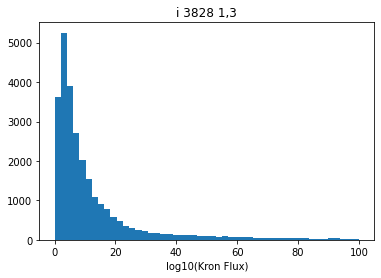

In [33]:
plt.figure()
plt.hist(coadd_sources['ext_photometryKron_KronFlux_instFlux'],bins=np.linspace(0,100,50))
plt.xlabel("log10(Kron Flux)")
plt.title("{filter} {tract} {patch}".format(filter=filter,tract=tract,patch=patch))

# Summary

We have shown a few techniques for exploring a data repo. ~~To make this process straightforward, we are implementing all these techniques into methods of a `Taster` class, which is now a part of the `stackclub` library. The `Taster` will give you a taste of what the `Butler` delivers. we demonstrate the use of this class in the [DataInventory.ipynb](https://github.com/LSSTScienceCollaborations/StackClub/blob/dc2_gen2/Graveyard/DataInventory.ipynb) notebook.~~

(Note:  the `Taster` class and the [DataInventory.ipynb](https://github.com/LSSTScienceCollaborations/StackClub/blob/dc2_gen2/Graveyard/DataInventory.ipynb) notebook are now both deprecated.  The DataInventory notebook is largely a demonstration of the `Taster` class, a useful tool that was created to augment the deficiencies of the Gen-2 butler for investigating and exploring data repos. Unfortunately, it depends on classes and repo structures that have evolved substantially over the past few years. Since the `Taster` resides outside of the DM Stack, it requires constant maintenance to be kept up-to-date with the Stack.  With the impending release of the Gen-3 butler, the `Taster` and the DataInventory notebook have been deprecated.)